# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
11372,17591,62543,England,21-03-2020,Up at 06.40 this morning to put ten horses out...,Negative
29828,40420,85372,By the Lake Oakland,09-04-2020,You know shits fucked up when going to the gro...,Extremely Negative
31752,42861,87813,NaN,12-04-2020,"Get a handy 30ml sanitizer bottle, Indus Valle...",Positive
4961,9835,54787,"16 Park Road, Cheltenham",19-03-2020,gov warns of scammers exploiting to sell fraud...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [3]:
# -- YOUR CODE HERE --
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Positive', 'Extremely Positive'] else 0)
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


Сбалансированы ли классы?

In [4]:
# -- YOUR CODE HERE --
total = df['Sentiment'].value_counts().sum()
part_1 = ((df['Sentiment'] == 1).sum())/total * 100
part_0 = ((df['Sentiment'] == 0).sum())/total * 100
print(f'баланс классов: {part_1:.2f}% / {part_0:.2f}%')

баланс классов: 53.96% / 46.04%


**Ответ:** # -- YOUR ANSWER HERE --
 **Да. Классы почти идеально сбалансированы**

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [5]:
# -- YOUR CODE HERE --
print('Информация о пропусках в данных')
print(df.isna().sum())
df = df.fillna('Unknown')

Информация о пропусках в данных
UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0) # -- YOUR CODE HERE --

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [7]:
# -- YOUR CODE HERE --
tokens_dict = {}
for tweet in df['OriginalTweet']:
  tokenized_tweet = str(tweet).lower().split()
  for token in tokenized_tweet:
    if token in tokens_dict:
      tokens_dict[token] += 1
    else:
      tokens_dict[token] = 1
tokens_dict

{'advice': 195,
 'talk': 115,
 'to': 33447,
 'your': 3999,
 'neighbours': 24,
 'family': 392,
 'exchange': 25,
 'phone': 114,
 'numbers': 72,
 'create': 117,
 'contact': 271,
 'list': 250,
 'with': 5764,
 'of': 18578,
 'schools': 78,
 'employer': 17,
 'chemist': 19,
 'gp': 9,
 'set': 231,
 'up': 2875,
 'online': 2388,
 'shopping': 2300,
 'accounts': 34,
 'if': 3058,
 'poss': 1,
 'adequate': 30,
 'supplies': 537,
 'regular': 101,
 'meds': 18,
 'but': 3082,
 'not': 3873,
 'over': 1112,
 'order': 485,
 'coronavirus': 1376,
 'australia:': 1,
 'woolworths': 15,
 'give': 404,
 'elderly,': 19,
 'disabled': 69,
 'dedicated': 63,
 'hours': 389,
 'amid': 798,
 'covid-19': 4504,
 'outbreak': 573,
 'https://t.co/binca9vp8p': 1,
 'my': 3557,
 'food': 5409,
 'stock': 1525,
 'is': 10596,
 'the': 38250,
 'only': 1188,
 'one': 1548,
 'which': 729,
 'empty...': 3,
 'please,': 36,
 "don't": 778,
 'panic,': 71,
 'there': 1710,
 'will': 3865,
 'be': 5058,
 'enough': 501,
 'for': 12193,
 'everyone': 854,
 '

Какой размер словаря получился?

In [8]:
# -- YOUR CODE HERE --
len(tokens_dict)

103200

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [9]:
# -- YOUR CODE HERE --
for token, count in (sorted(tokens_dict.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')

the: 38250
to: 33447
and: 20935
of: 18578
a: 16667
in: 16024
for: 12193
#coronavirus: 11759
is: 10596
are: 9958


**Ответ:** # -- YOUR ANSWER HERE --
**Эти токены в топе из-за того, что эти слова - служебные для английского языка (частицы, предлоги и т.д.). Еще есть слово "коронавирус", которое здесь по причине того, что датафрейм о твитах про коронавирус.**

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [10]:
!pip install nltk

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# -- YOUR CODE HERE --
tokens_dict_without_stopwords = dict(filter(lambda item: item[0] not in stopwords.words("english"), tokens_dict.items()))
for token, count in (sorted(tokens_dict_without_stopwords.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#coronavirus: 11759
prices: 5625
food: 5409
grocery: 4882
supermarket: 4662
covid-19: 4504
people: 4488
store: 4486
#covid19: 3561
consumer: 3233


**Ответ:**  # -- YOUR ANSWER HERE --
**Про список можно сказать, что 3 слова - коронавирус. Есть слово люди. Остальные слова связаны с магазинами. Выглядит правдободобно.**

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [12]:
# -- YOUR CODE HERE --
for token, count in (sorted(tokens_dict_without_stopwords.items(), key=lambda item: item[1])[:20]):
  print(f'{token}: {count}')

poss: 1
australia:: 1
https://t.co/binca9vp8p: 1
#confinementgeneral: 1
https://t.co/zrlg0z520j: 1
litteraly: 1
#coronavirusfrance: 1
https://t.co/usmualq72n: 1
@tim_dodson: 1
https://t.co/cfxch7a2lu: 1
civics: 1
about".: 1
https://t.co/iefdnehgdo: 1
https://t.co/kw91zj5o5i: 1
prevention,we: 1
19?.: 1
#govindia: 1
#horningsea: 1
https://t.co/lsgrxxhjhh: 1
https://t.co/8ywakfjexc: 1


**Ответ:** # -- YOUR ANSWER HERE --
Эти токены непопулярны, потому что они уникальны. Например: ссылки, упоминания людей через @, непопулярные хэштэги, ошибка в слове "litteraly". Что-то стало уникальным из-за токенизации, например: 19?.
Дополнительно с ними работать не требуется, так как они имеют очень маленькую значимость и не влияют на общую картину.


Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [13]:
from nltk.tokenize import TweetTokenizer

# -- YOUR CODE HERE --
tw = TweetTokenizer()
tweet_tokenized_dict = {}
for tweet in df['OriginalTweet']:
  tw_tokenized_tweet = tw.tokenize(tweet)
  for token in tw_tokenized_tweet:
    if token in tweet_tokenized_dict:
      tweet_tokenized_dict[token] += 1
    else:
      tweet_tokenized_dict[token] = 1
for token, count in (sorted(tweet_tokenized_dict.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')


the: 34781
.: 34284
to: 32812
,: 25142
and: 20439
of: 18429
a: 15679
in: 15143
?: 13730
for: 11722


**Ответ:** # -- YOUR ANSWER HERE -- Отличается наличием знаков препинания. Отличие в том, что TweetTokenizer - специально создан для работы с твитами, поэтому он умеет отделять всякие символы от слов. Так и произошло с **"."**, **","**, **"?"**.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [14]:
from string import punctuation

# -- YOUR CODE HERE --
noise = stopwords.words("english") + list(punctuation)
tweet_tokenized_dict_without_stopwords = dict(filter(lambda item: item[0] not in noise, tweet_tokenized_dict.items()))
for token, count in (sorted(tweet_tokenized_dict_without_stopwords.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')

Â: 10498
: 10361
#coronavirus: 10211
19: 10142
I: 7484
: 6190
prices: 6166
COVID: 5945
food: 5423
store: 5234


**Ответ:** # -- YOUR ANSWER HERE -- Есть

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [15]:
# -- YOUR CODE HERE --
tweet_tokenized_dict_without_stopwords_and_special_symbols = dict(filter(lambda item: not (len(item[0]) == 1 and ord(item[0]) >= 128), tweet_tokenized_dict_without_stopwords.items()))
print('Топ-10 самых популярных слов')
for token, count in (sorted(tweet_tokenized_dict_without_stopwords_and_special_symbols.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')
print('------------')
print('Топ-20 самых непопулярных слов')
for token, count in (sorted(tweet_tokenized_dict_without_stopwords_and_special_symbols.items(), key=lambda item: item[1])[:20]):
  print(f'{token}: {count}')

Топ-10 самых популярных слов
#coronavirus: 10211
19: 10142
I: 7484
prices: 6166
COVID: 5945
food: 5423
store: 5234
supermarket: 4803
grocery: 4350
people: 4300
------------
Топ-20 самых непопулярных слов
poss: 1
https://t.co/bInCA9Vp8P: 1
#ConfinementGeneral: 1
https://t.co/zrlG0Z520j: 1
litteraly: 1
#CoronavirusFrance: 1
https://t.co/usmuaLq72n: 1
@Tim_Dodson: 1
https://t.co/cfXch7a2lU: 1
Civics: 1
https://t.co/ieFDNeHgDO: 1
https://t.co/kw91zJ5O5i: 1
#govindia: 1
#horningsea: 1
https://t.co/lsGrXXhjhh: 1
https://t.co/8YWaKFjExC: 1
ADARA: 1
Up-To-Date: 1
https://t.co/PnA797jDKV: 1
https://t.co/dQox6uSihz: 1


**Ответ:** # -- YOUR ANSWER HERE --
Разница заметна в том, что количество одних и тех же слов отличается. Например в первом словаре #coronavirus = 11759, а во втором - 10142. Еще в новые топы вошли новые слова. Например: "19", "I" в топ-10 и т.д. В данном случае лучше разделены слова (теперь нет таких ситуаций, когда слово слилось со знаком препинания). Возможно хуже то, что в новом топ-10 есть такие слова как "19", "I", вряд ли они могут дать какую-то ясность при анализе.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [16]:
from ast import keyword
# -- YOUR CODE HERE --
hashtags_dict = dict(filter(lambda item: item[0].startswith('#'), tweet_tokenized_dict_without_stopwords_and_special_symbols.items()))
for token, count in (sorted(hashtags_dict.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')

#coronavirus: 10211
#COVID19: 2621
#Covid_19: 2126
#Coronavirus: 1806
#COVID2019: 1341
#toiletpaper: 944
#covid19: 829
#COVID: 775
#CoronaCrisis: 599
#CoronaVirus: 525


**Ответ:** # -- YOUR ANSWER HERE -- 9 твитов про коронавирус и 1 про toilet бумагу. Учитывая то, что датафрейм про твиты на тему коронавируса, всё логично.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [17]:
# -- YOUR CODE HERE --
links_dict = dict(filter(lambda item: item[0].startswith('https://t.co'), tweet_tokenized_dict_without_stopwords_and_special_symbols.items()))
for token, count in (sorted(links_dict.items(), key=lambda item: item[1], reverse=True)[:10]):
  print(f'{token}: {count}')

https://t.co/oXA7SWtoNd: 6
https://t.co/G63RP042HO: 5
https://t.co/R7sAGojsjg: 4
https://t.co/WrLHYzIzAA: 4
https://t.co/ymsEmlVTTd: 4
https://t.co/3kFUIOJXEp: 4
https://t.co/OI39zSAnQ8: 4
https://t.co/6yVYKIAb2c: 4
https://t.co/xPcm2Xkj4O: 4
https://t.co/gu6B4XpqP4: 4


**Ответ:** # -- YOUR ANSWER HERE --
хэштэг на 10 месте популярнее ссылки на 1 месте в 87,5 раз. Суммарное количество хэштэгов в топ-10 намного больше суммарного количества ссылок в топ-10. Вообщем популярность несравнима. Информация о ссылке полезна, так как нам будут интересны страницы, на которые ссылались много раз.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [18]:
def custom_tokenizer(text):

  # -- YOUR CODE HERE --
  lower_text = text.lower()
  tw = TweetTokenizer()
  tweet_tokenize_tokens = tw.tokenize(lower_text)
  tokens = [token for token in tweet_tokenize_tokens if (token not in stopwords.words("english") and token not in punctuation and
            not (len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co')))]

  return tokens


In [19]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer) # -- YOUR CODE HERE --
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


**Ответ:** # -- YOUR ANSWER HERE -- Размер полученного словаря примерно в 2.3 раза больше чем размер словаря из начала задания 2

Посмотрим на какой-нибудь конкретный твитт:

In [21]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']


('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [22]:
# -- YOUR CODE HERE --
vector_text = cv.transform([train.iloc[ind]['OriginalTweet']])
feature_names = cv.get_feature_names_out()

nonzero_indices = vector_text.indices
nonzero_data = vector_text.data

if len(nonzero_data) > 0:
    max_token = feature_names[nonzero_indices[np.argmax(nonzero_data)]]
    min_token = feature_names[nonzero_indices[np.argmin(nonzero_data)]]
    print("самый важный токен:", max_token)
    print("самый неважный токен:", min_token)
print({feature_names[i]: count for i, count in zip(vector_text.indices, vector_text.data)})

самый важный токен: #coronavirusoutbreak
самый неважный токен: #coronavirusoutbreak
{'#coronavirusoutbreak': np.int64(1), '#covid2019': np.int64(1), '@skynews': np.int64(1), 'brainless': np.int64(1), 'ffs': np.int64(1), 'food': np.int64(1), 'france': np.int64(1), 'lets': np.int64(1), 'nice': np.int64(1), 'one': np.int64(1), 'panic': np.int64(1), 'ppl': np.int64(1), 'queueing': np.int64(1), 'show': np.int64(1)}


**Ответ:** # -- YOUR ANSWER HERE -- Определились плохо, так как данный векторизатор учитывает насколько часто слово встречается в данном тексте, но не учитывает то, насколько часто слова встречаются во всех текстах.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [23]:
# -- YOUR CODE HERE --
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tv.fit(train['OriginalTweet'])
vector_txt = tv.transform([train.iloc[ind]['OriginalTweet']])

feature_names = tv.get_feature_names_out()
nonzero_indices = vector_txt.indices
nonzero_data = vector_txt.data

if len(nonzero_data) > 0:
    max_idx = nonzero_indices[np.argmax(nonzero_data)]
    min_idx = nonzero_indices[np.argmin(nonzero_data)]

    max_token = feature_names[max_idx]
    min_token = feature_names[min_idx]
    print("самый важный токен:", max_token)
    print("самый неважный токен:", min_token)
print({feature_names[i]: count for i, count in zip(vector_text.indices, vector_text.data)})

самый важный токен: brainless
самый неважный токен: food
{'#coronavirusoutbreak': np.int64(1), '#covid2019': np.int64(1), '@skynews': np.int64(1), 'brainless': np.int64(1), 'ffs': np.int64(1), 'food': np.int64(1), 'france': np.int64(1), 'lets': np.int64(1), 'nice': np.int64(1), 'one': np.int64(1), 'panic': np.int64(1), 'ppl': np.int64(1), 'queueing': np.int64(1), 'show': np.int64(1)}


**Ответ:** # -- YOUR ANSWER HERE -- токены хорошо определились, так как tf-idf определил важность слов по тому, насколько часто они встречаются в этом тексте и насколько часто они встречается во всех текстах.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [24]:
train[train['OriginalTweet'].apply(lambda x: 'your_good_word_here' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [25]:
# -- YOUR CODE HERE --
positive_tweet = train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)].iloc[1]['OriginalTweet']
print(positive_tweet)
vector_positive_tweet = tv.transform([positive_tweet])

feature_names = tv.get_feature_names_out()
nonzero_indices = vector_positive_tweet.indices
nonzero_data = vector_positive_tweet.data

if len(nonzero_data) > 0:
    max_idx = nonzero_indices[np.argmax(nonzero_data)]
    max_token = feature_names[max_idx]
    print("самый важный токен:", max_token)
print({feature_names[i]: count for i, count in zip(vector_positive_tweet.indices, vector_positive_tweet.data)})

Let s just take a minute to say THANK YOU also to the amazing postal workers So many real people behind a click of online shopping and getting cards delivered Thank   you   19
самый важный токен: thank
{'19': np.float64(0.08634631973114962), 'also': np.float64(0.17861928808211905), 'amazing': np.float64(0.2500353203109799), 'behind': np.float64(0.2543173563271987), 'cards': np.float64(0.28099848030535446), 'click': np.float64(0.2568671614420422), 'delivered': np.float64(0.2577554530925274), 'getting': np.float64(0.19726227818071365), 'let': np.float64(0.21263423966251035), 'many': np.float64(0.1705077944503823), 'minute': np.float64(0.294475932823674), 'online': np.float64(0.14234788335294127), 'people': np.float64(0.11898135781908495), 'postal': np.float64(0.29936770273835617), 'real': np.float64(0.219253456253651), 'say': np.float64(0.20055018776835393), 'shopping': np.float64(0.1396748768304228), 'take': np.float64(0.1764282133522333), 'thank': np.float64(0.3691299729428482), 'worke

**Ответ:** # -- YOUR ANSWER HERE -- у меня самым важным словом стало слово 'thank'. Пользователь выражает благодарность, что указывает нам на положительную окраску твита.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [26]:
# -- YOUR CODE HERE --
X_train_cv = cv.fit_transform(train['OriginalTweet'])
X_test_cv = cv.transform(test['OriginalTweet'])

X_train_tv = tv.fit_transform(train['OriginalTweet'])
X_test_tv = tv.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -- YOUR CODE HERE --
logreg_cv = LogisticRegression()
logreg_tv = LogisticRegression()

logreg_cv.fit(X_train_cv, y_train)
y_pred_train_cv = logreg_cv.predict(X_train_cv)
y_pred_test_cv = logreg_cv.predict(X_test_cv)

logreg_tv.fit(X_train_tv, y_train)
y_pred_train_tv = logreg_tv.predict(X_train_tv)
y_pred_test_tv = logreg_tv.predict(X_test_tv)

train_cv_accuracy = accuracy_score(y_train, y_pred_train_cv)
train_tv_accuracy = accuracy_score(y_train, y_pred_train_tv)
test_cv_accuracy = accuracy_score(y_test, y_pred_test_cv)
test_tv_accuracy = accuracy_score(y_test, y_pred_test_tv)

print('Count_vectorizor:')
print(f'точность на трейне: {train_cv_accuracy:.4f}')
print(f'точность на тесте: {test_cv_accuracy:.4f}')
print('--------------------------')
print('Tfidf_vectorizor:')
print(f'точность на трейне: {train_tv_accuracy:.4f}')
print(f'точность на тесте: {test_tv_accuracy:.4f}')

Count_vectorizor:
точность на трейне: 0.9847
точность на тесте: 0.8671
--------------------------
Tfidf_vectorizor:
точность на трейне: 0.9224
точность на тесте: 0.8528


**Ответ:** # -- YOUR ANSWER HERE -- Можно заметить, что в случае с Count_vectorizor модель сильно переобучилась. В случае с Tfidf_vectorizer тоже переобучилась, но меньше. Лучший результат на тесте показал Count_vectorizer.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [28]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
def custom_stem_tokenizer(text):
  # -- YOUR CODE HERE --
  lower_text = text.lower()
  tw = TweetTokenizer()
  tweet_tokenize_tokens = tw.tokenize(lower_text)
  tokens = [stemmer.stem(token) for token in tweet_tokenize_tokens if (token not in stopwords.words("english") and token not in punctuation and
            not (len(token) == 1 and ord(token) >= 128) and not(token.startswith('https://t.co')))]
  return tokens

In [29]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

36652

In [30]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer) # -- YOUR CODE HERE --
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_train_cv = cv.fit_transform(train['OriginalTweet'])
X_test_cv = cv.transform(test['OriginalTweet'])

X_train_tv = tv.fit_transform(train['OriginalTweet'])
X_test_tv = tv.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']
print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


**Ответ** # -- YOUR ANSWER HERE --
был: 45290 слов
стал: 36634 слова

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [31]:
# -- YOUR CODE HERE --
logreg_cv = LogisticRegression()
logreg_tv = LogisticRegression()

logreg_cv.fit(X_train_cv, y_train)
y_pred_train_cv = logreg_cv.predict(X_train_cv)
y_pred_test_cv = logreg_cv.predict(X_test_cv)

logreg_tv.fit(X_train_tv, y_train)
y_pred_train_tv = logreg_tv.predict(X_train_tv)
y_pred_test_tv = logreg_tv.predict(X_test_tv)

train_cv_accuracy = accuracy_score(y_train, y_pred_train_cv)
train_tv_accuracy = accuracy_score(y_train, y_pred_train_tv)
test_cv_accuracy = accuracy_score(y_test, y_pred_test_cv)
test_tv_accuracy = accuracy_score(y_test, y_pred_test_tv)

print('CountVectorizer со стеммингом:')
print(f'Точность на трейне: {train_cv_accuracy:.4f}')
print(f'Точность на тесте:  {test_cv_accuracy:.4f}')
print('--------------------------')
print('TfidfVectorizer со стеммингом:')
print(f'Точность на трейне: {train_tv_accuracy:.4f}')
print(f'Точность на тесте:  {test_tv_accuracy:.4f}')

CountVectorizer со стеммингом:
Точность на трейне: 0.9720
Точность на тесте:  0.8675
--------------------------
TfidfVectorizer со стеммингом:
Точность на трейне: 0.9166
Точность на тесте:  0.8560


**Ответ:** # -- YOUR ANSWER HERE -- Качество на тесте незначительно улучшилось(count_vectorizer на тесте: 0,8671 -> 0,8675, tfidf_vectorizer на тесте: 0,8528 -> 0,8560). Нет смысла применять стемминг.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

размер моего словаря был 36634

In [32]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000 # -- YOUR CODE HERE --
                        ).fit(
                            # -- YOUR CODE HERE --
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


Суть задания была в том, чтобы выкинуть из словаря самый популярный токен. Чтобы это сделать, потребовалось подобрать такой max_df, который был бы меньше количества встречаний самого популярного токена и больше количества встречаний второго по популярности токена.
Из-за того, что второй по популярности токен встречается больше 6000 раз, max_df пришлось взять таким большим.

In [33]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

в моем случае размер словаря должен получиться на 18 меньше, то есть 3682

In [34]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11 # -- YOUR CODE HERE --
                        ).fit(
                            # -- YOUR CODE HERE --
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3687


нужное значение никак не получается, возьму ближайшее возможное к нему - 3687

In [35]:
# -- YOUR CODE HERE --
X_train_cv_df = cv_df.transform(train['OriginalTweet'])
X_test_cv_df = cv_df.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']

logreg_cv_df = LogisticRegression()

logreg_cv_df.fit(X_train_cv_df, y_train)
y_pred_train_cv_df = logreg_cv_df.predict(X_train_cv_df)
y_pred_test_cv_df = logreg_cv_df.predict(X_test_cv_df)

train_cv_accuracy = accuracy_score(y_train, y_pred_train_cv_df)
test_cv_accuracy = accuracy_score(y_test, y_pred_test_cv_df)

print('CountVectorizer со стеммингом:')
print(f'Точность на трейне: {train_cv_accuracy:.4f}')
print(f'Точность на тесте:  {test_cv_accuracy:.4f}')

CountVectorizer со стеммингом:
Точность на трейне: 0.9290
Точность на тесте:  0.8680


**Ответ:** # -- YOUR ANSWER HERE -- Точность на тесте была 0,8675, стала 0,8680 то есть хуже не стало.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

точность на трейне: 0.9415
точность на тесте: 0.8447


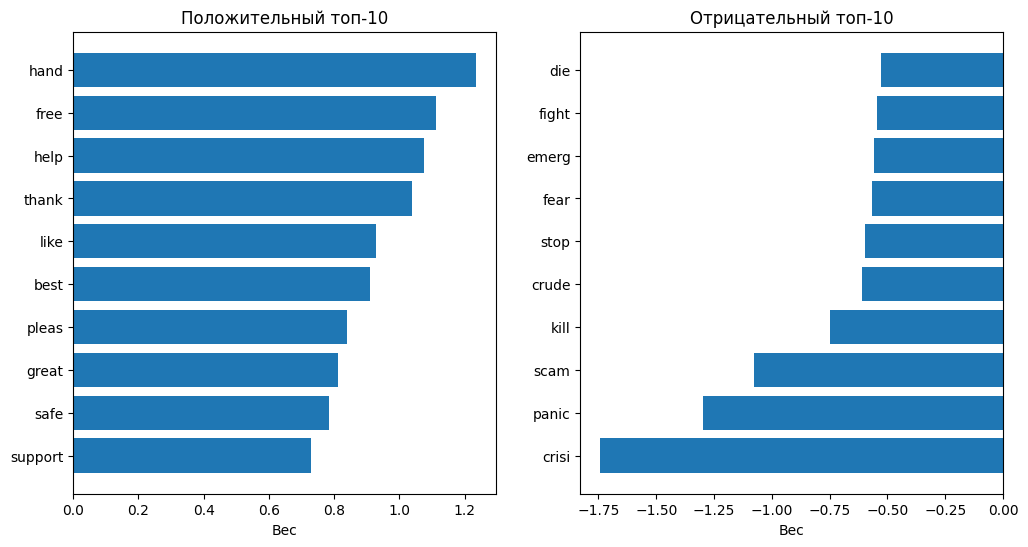

In [36]:
from sklearn.preprocessing import StandardScaler
# -- YOUR CODE HERE --
scaler = StandardScaler(with_mean=False)

X_train_cv_df_scaled = scaler.fit_transform(X_train_cv_df)
X_test_cv_df_scaled = scaler.transform(X_test_cv_df)

logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_train_cv_df_scaled, y_train)

y_pred_train_scaled = logreg_scaled.predict(X_train_cv_df_scaled)
y_pred_test_scaled = logreg_scaled.predict(X_test_cv_df_scaled)

train_accuracy = accuracy_score(y_train, y_pred_train_scaled)
test_accuracy = accuracy_score(y_test, y_pred_test_scaled)

print(f'точность на трейне: {train_accuracy:.4f}')
print(f'точность на тесте: {test_accuracy:.4f}')

tokens_list = cv_df.get_feature_names_out()
w_list = logreg_scaled.coef_[0]

top_most_positive_tokens = np.argsort(w_list)[-10:]
top_most_negative_tokens = np.argsort(w_list)[:10]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(np.array(tokens_list)[top_most_positive_tokens], w_list[top_most_positive_tokens])
plt.title('Положительный топ-10')
plt.xlabel('Вес')

plt.subplot(1, 2, 2)
plt.barh(np.array(tokens_list)[top_most_negative_tokens], w_list[top_most_negative_tokens])
plt.title('Отрицательный топ-10')
plt.xlabel('Вес')

plt.show()


**Ответ:** # -- YOUR ANSWER HERE -- Выглядит всё логично. В топ-10 положительных токенов входят слова, которые наталкивают на мысль о позитивной окраске твита. В топ-10 негативных токенов входят слова, которые наталкивают на мысль о негативной окраске твита

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [37]:
# -- YOUR CODE HERE --
print(train['UserName'].nunique())
print(train['ScreenName'].nunique())
train.shape

23410
23410


(23410, 6)

**Ответ:** # -- YOUR ANSWER HERE -- Они бесполезны, так как все значения уникальны (количество уникальных значений в столбце у юзернэйм и скриннэйм совпадает с количеством строк в датафрейме). Из-за этого модель не выведет никакой закономерности с помощью этих данных.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [38]:
# -- YOUR CODE HERE --
from datetime import datetime
train['TweetAt'] = train['TweetAt'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y'))
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
25621,35178,80130,Unknown,2020-04-06,Why we still want to buy so much stuff during ...,1
30135,40819,85771,"Boston, MA HQ",2020-04-10,With driving even more usage a strong strategy...,1
28899,39249,84201,India,2020-04-09,@Canon_India I am very happy.. Great job by @C...,1
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1
...,...,...,...,...,...,...
20757,29120,74072,Unknown,2020-03-31,Football is in ruins right now.When it will re...,0
32103,43291,88243,"Waterville, Ireland Austin, TX",2020-04-13,Hand sanitizer made here on the Skellig Coast!...,1
30403,41159,86111,"Mumbai , Delhi India",2020-04-10,An initiative taken by our @GOLDENINITIATI1 ...,1
21243,29702,74654,Unknown,2020-04-01,Vile premiership players demanding full wages ...,0


In [39]:
train['TweetAt'].nunique()

30

**Ответ:** # -- YOUR ANSWER HERE -- Столбец 'TweetAt' полезен, так как там всего 30 уникальных значений на весь датафрейм из 23410 строк. Модель сможет заметить какие-то закономерности.



<Axes: xlabel='TweetAt', ylabel='Count'>

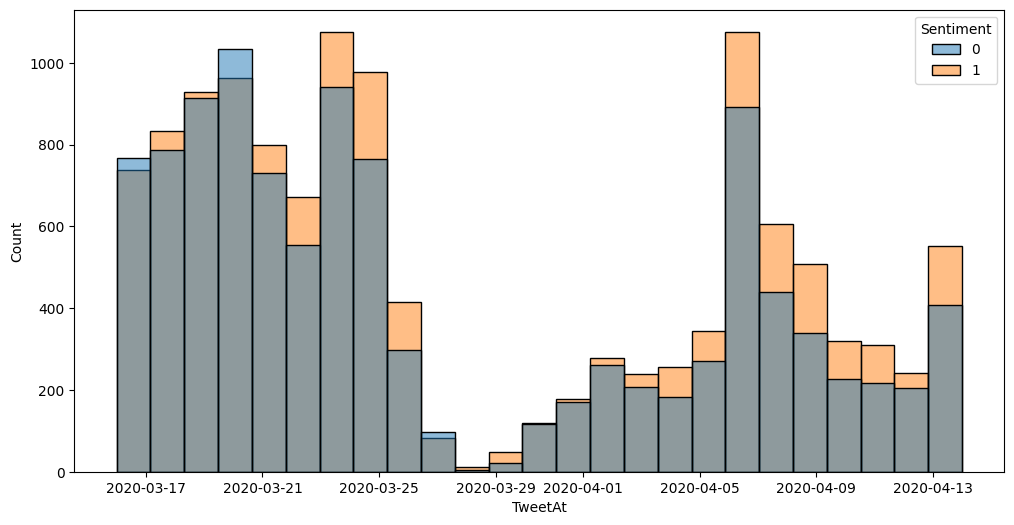

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.histplot(data=train, x='TweetAt', hue='Sentiment')

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [41]:
# -- YOUR CODE HERE --
train['Location'].nunique()

7949

7949 уникальных значений

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

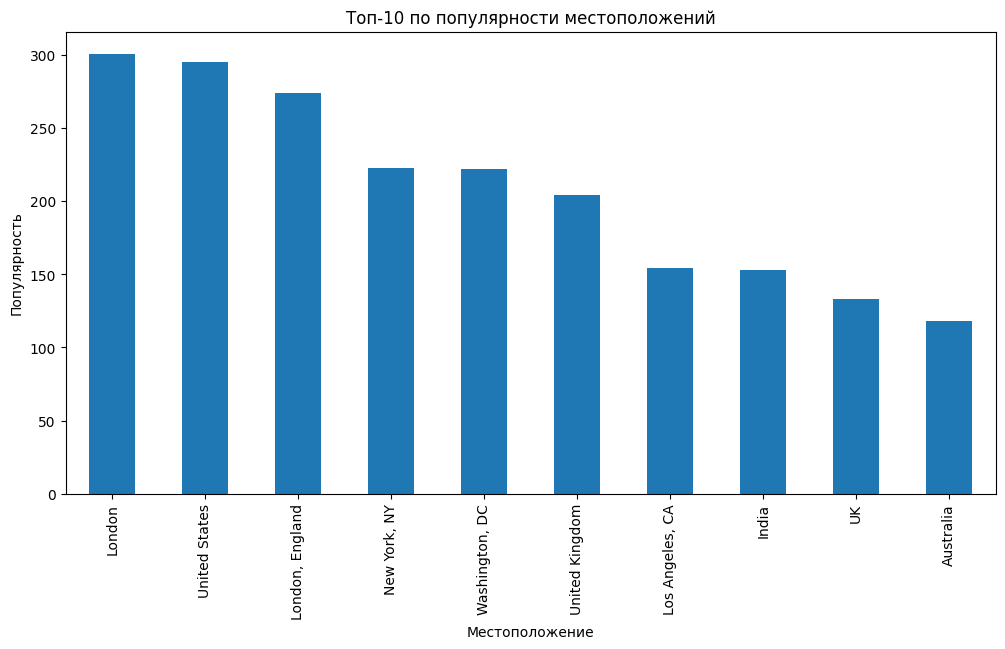

In [42]:
# -- YOUR CODE HERE --
loc_top_10 = train['Location'].value_counts()[1:11]

plt.figure(figsize=(12, 6))
loc_top_10.plot(kind='bar')

plt.title('Топ-10 по популярности местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Популярность')
plt.show()



Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

теперь 4631 уникальных категорий


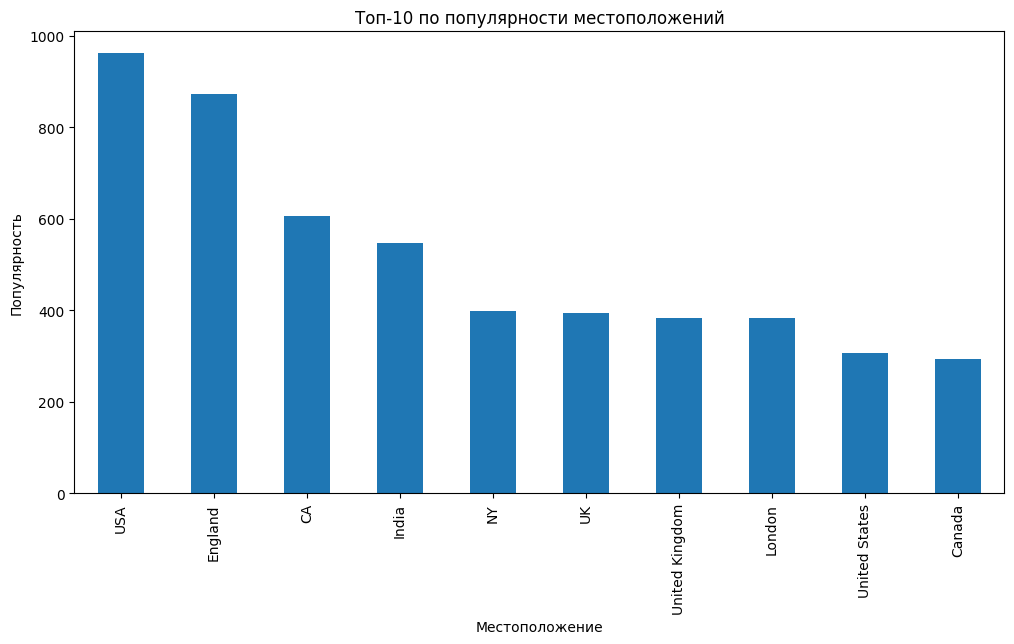

In [43]:
# -- YOUR CODE HERE --
train['Location'].nunique()
train['WiderLocation'] = train['Location'].str.split(',').str[-1].str.strip()
c = train['WiderLocation'].nunique()
wider_loc_top_10 = train['WiderLocation'].value_counts()[1:11]

print(f'теперь {c} уникальных категорий')



plt.figure(figsize=(12, 6))
wider_loc_top_10.plot(kind='bar')

plt.title('Топ-10 по популярности местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Популярность')
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# -- YOUR CODE HERE --
wider_location = train['WiderLocation'].value_counts()
wider_location_more_1 = wider_location[wider_location > 1].index
WiderLocation_OHE = pd.get_dummies(train.loc[train['WiderLocation'].isin(wider_location_more_1), 'WiderLocation'],
                                   prefix='WiderLocation')
WiderLocation_OHE

,WiderLocation_,WiderLocation_#Africa,WiderLocation_#BayArea #SouthBay Bureau,WiderLocation_#OKC?? PGH??&Colombo-5??,WiderLocation_#RemoteWork #Boston #NYC,WiderLocation_#WeAreThePatriots,WiderLocation_& Sacramento,WiderLocation_-80.143211,WiderLocation_-85.959195,WiderLocation_127.0.0.1,...,WiderLocation_uk,WiderLocation_up,WiderLocation_usa,WiderLocation_washington,WiderLocation_will travel,WiderLocation_world,WiderLocation_worldwide,WiderLocation_y'all,WiderLocation_||somali|kenyan??,WiderLocation_ÃÂ¯\_(?)_/ÃÂ¯
25621,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28899,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5989,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21350,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15378,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32103,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30403,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21243,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
from sklearn.preprocessing import OneHotEncoder

wider_location = train['WiderLocation'].value_counts()
wider_location_more_1 = wider_location[wider_location > 1].index

encoder = OneHotEncoder(categories=[[wider_location_more_1]], sparse_output=False)

WiderLocation_OHE = encoder.fit_transform([train['WiderLocation']])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# -- YOUR CODE HERE --
new_train = pd.concat([train, WiderLocation_OHE], axis=1).fillna(0)

lr = LogisticRegression()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,WiderLocation,WiderLocation_,WiderLocation_#Africa,WiderLocation_#BayArea #SouthBay Bureau,...,WiderLocation_uk,WiderLocation_up,WiderLocation_usa,WiderLocation_washington,WiderLocation_will travel,WiderLocation_world,WiderLocation_worldwide,WiderLocation_y'all,WiderLocation_||somali|kenyan??,WiderLocation_ÃÂ¯\_(?)_/ÃÂ¯
25621,35178,80130,Unknown,2020-04-06,Why we still want to buy so much stuff during ...,1,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30135,40819,85771,"Boston, MA HQ",2020-04-10,With driving even more usage a strong strategy...,1,MA HQ,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28899,39249,84201,India,2020-04-09,@Canon_India I am very happy.. Great job by @C...,1,India,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5989,11068,56020,"Mayfair, London, UK",2020-03-19,The U.S national debt will likely exceed $30 T...,0,UK,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4367,9109,54061,WNC,2020-03-18,"Finally got to the grocery store. Honestly, wh...",1,WNC,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,29120,74072,Unknown,2020-03-31,Football is in ruins right now.When it will re...,0,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False
32103,43291,88243,"Waterville, Ireland Austin, TX",2020-04-13,Hand sanitizer made here on the Skellig Coast!...,1,TX,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30403,41159,86111,"Mumbai , Delhi India",2020-04-10,An initiative taken by our @GOLDENINITIATI1 ...,1,Delhi India,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21243,29702,74654,Unknown,2020-04-01,Vile premiership players demanding full wages ...,0,Unknown,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Ответ:** # -- YOUR ANSWER HERE --

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)

MSE = mean_squared_error(y_test, y_pred_test)

In [ ]:
base_tree = DecisionTreeRegressor(random_state=123)
br = BaggingRegression(base_tree, n_estimators=20)
br.fit(X_train, y_train)
y_train_pred = br.predict(X_train)
y_test_pred = br.predict(X_test)

mse1 = mean_squared_error(y_train, y_pred_train)
mse2 = mean_squared_error(y_test, y_pred_test)